In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

2023-04-03 22:53:10.865039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
noise_filter = True

In [3]:
data_files = glob.glob("data/composite_data/2016*.npy")

data_matrix = np.empty([len(data_files),100,360,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    if data_point.shape[0] == 100:
        data_matrix[idx] = data_point
    else:
        print(data_point.shape, data_file)

data_matrix[:,:,:,0] = np.clip(data_matrix[:,:,:,0], 0, 5000)
data_matrix[:,:,:,1] = np.clip(data_matrix[:,:,:,1], 0, 3000)
data_matrix[:,:,:,2] = np.clip(data_matrix[:,:,:,2], -400, 400)

min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

rg = max_values - min_values

rg = np.fmax(rg, 1e-4)

data_matrix_norm = (data_matrix-min_values) / rg

# Normalize HMI magnetogram data differently
hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)

data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2

data_matrix_norm[np.isnan(data_matrix_norm)] = 0

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

(360, 100, 3) data/composite_data/2016-02-01T03-34-35.npy


/tmp/ipykernel_62323/1593128507.py:16: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_62323/1593128507.py:17: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_62323/1593128507.py:26: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_62323/1593128507.py:28: RuntimeWarning: invalid value encountered in divide
  data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2


(0.0, 1.0)

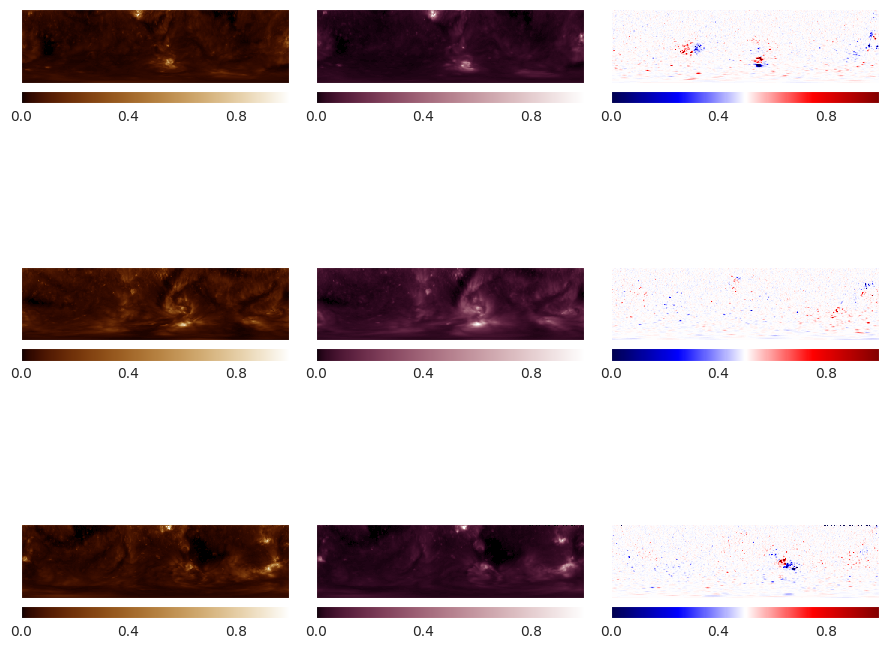

In [4]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)

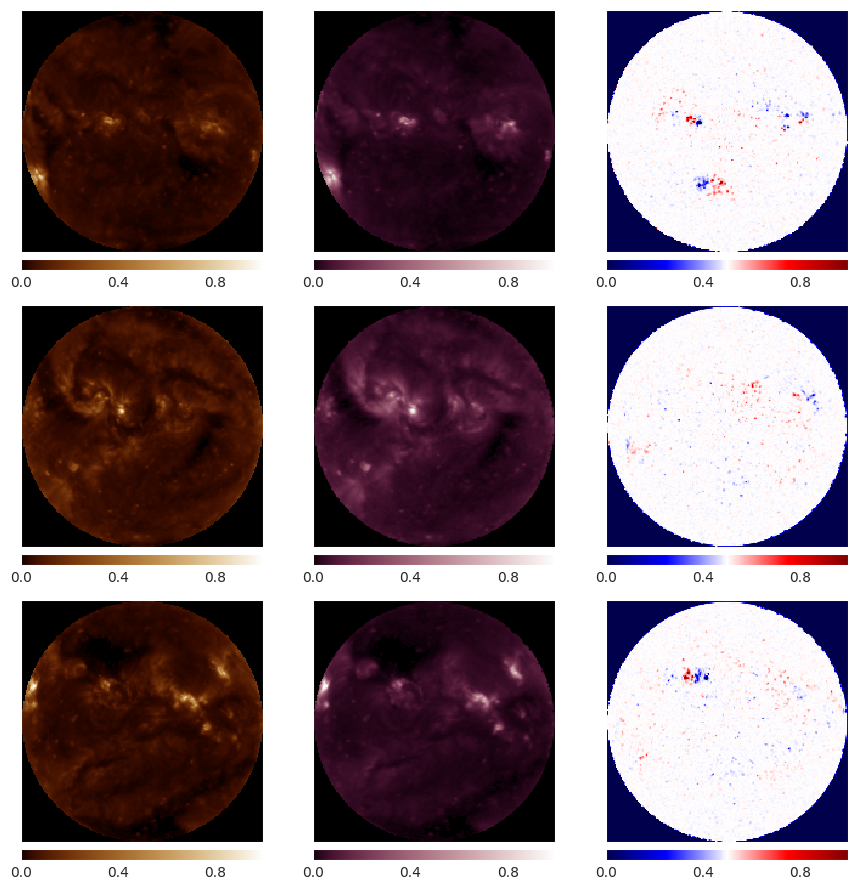

In [5]:
ax = isns.ImageGrid(image_list.copy(), col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, map_func=utils.polar_linear, orientation="h", vmin=0, vmax=1)

In [6]:
latent_size = 48
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD()
autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss="mse")

2023-04-03 22:53:25.317696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 22:53:25.332246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 22:53:25.332423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 cylindrical_padding2d (Cylindr  (None, 100, 362, 3)  0          ['input_1[0][0]']                
 icalPadding2D)                                                                                   
                                                                                                  
 conv2d (Conv2D)                (None, 49, 180, 32)  864         ['cylindrical_padding2d[0][0]']  
                                                                                              

In [7]:
n_epochs = 125
batch_size = 32

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/125


2023-04-03 22:53:31.269818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-03 22:53:32.419466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60/60 [==============================] - 16s 139ms/step - loss: 0.0373 - mae: 0.1137 - val_loss: 0.0213 - val_mae: 0.1076
Epoch 2/125
60/60 [==============================] - 6s 95ms/step - loss: 0.0072 - mae: 0.0475 - val_loss: 0.0128 - val_mae: 0.0859
Epoch 3/125
60/60 [==============================] - 6s 95ms/step - loss: 0.0059 - mae: 0.0417 - val_loss: 0.0105 - val_mae: 0.0752
Epoch 4/125
60/60 [==============================] - 6s 95ms/step - loss: 0.0057 - mae: 0.0405 - val_loss: 0.0085 - val_mae: 0.0663
Epoch 5/125
60/60 [==============================] - 6s 95ms/step - loss: 0.0055 - mae: 0.0399 - val_loss: 0.0074 - val_mae: 0.0608
Epoch 6/125
60/60 [==============================] - 6s 95ms/step - loss: 0.0054 - mae: 0.0392 - val_loss: 0.0062 - val_mae: 0.0534
Epoch 7/125
60/60 [==============================] - 6s 95ms/step - loss: 0.0054 - mae: 0.0386 - val_loss: 0.0054 - val_mae: 0.0475
Epoch 8/125
43/60 [====================>.........] - ETA: 1s - loss: 0.0053 - mae: 0.0

22/22 [==============================] - 1s 30ms/step - loss: 0.0046 - mae: 0.0330


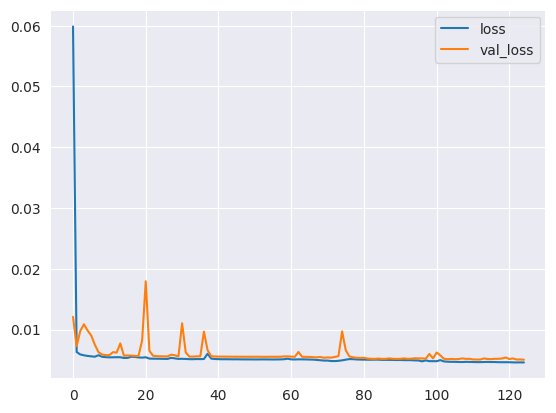

In [ ]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(1, 100, 360, 3)


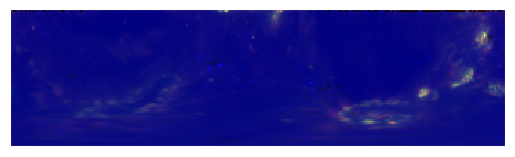

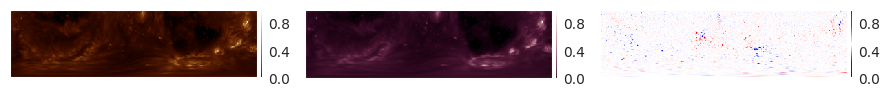

In [ ]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)
isns.imgplot(test_img[0])
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"])

<AxesSubplot: >

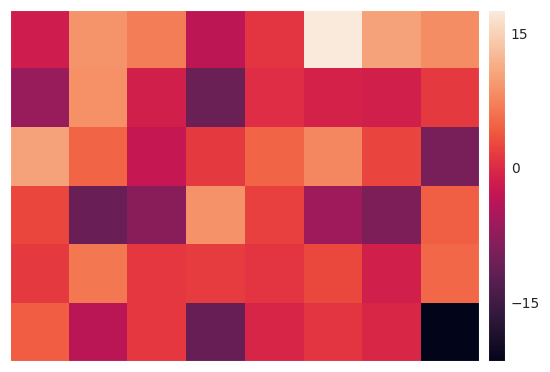

In [ ]:
code = encoder(test_img)
isns.imgplot(np.reshape(code[0], (6, 8)))

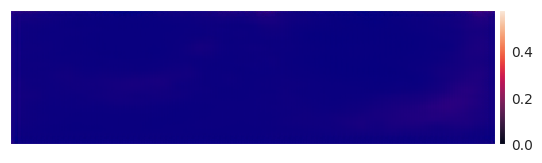

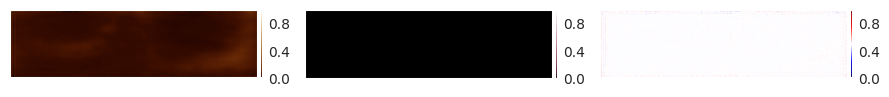

In [ ]:
decoded = decoder(code)
isns.imgplot(decoded[0])
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

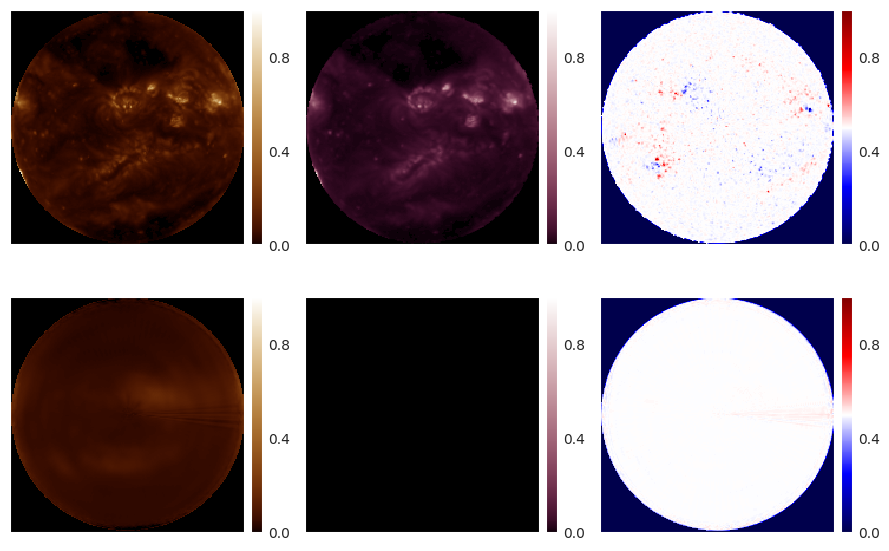

In [ ]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]


isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=0, vmax=1, map_func=utils.polar_linear)